In [2]:
import numpy as np
import pandas as pd
from sksurv.metrics import cumulative_dynamic_auc, integrated_brier_score, concordance_index_censored
from sksurv.util import Surv

# 1. Load your data
df_clin = pd.read_csv('./input_data/from_survival/clinical.csv', index_col=0) 
eta_preds = pd.read_csv('data/cv_final2_recover_from_droppedMrd_2/refactored_competing_risk_eta_per_cause_EFS_tuned_Combined_all_variants_no_cnv_fold0.csv', index_col=0) # Your precomputed risk scores (N, K)
annotations = pd.read_csv('./input_data/from_survival/annotations.csv', index_col=0)

# Ensure indices match
# common_idx = df_clin.index.intersection(eta_preds.index)
# df_clin = df_clin.loc[common_idx]
    
# eta_preds = eta_preds.loc[common_idx]



In [3]:
df_clin.head()

,OS_days,OS_status,EFS_days,EFS_status,DFS_days,DFS_status,Day_29_MRD
PARKES,2607.0,0.0,2606.0,0.0,2572.0,0.0,3.50
PARSET,359.0,0.0,356.0,0.0,NaN,NaN,0.00
PASJYI,3180.0,0.0,3179.0,0.0,3145.0,0.0,1.20
PATFRM,2983.0,0.0,2980.0,0.0,2945.0,0.0,0.10
PATISN,3197.0,0.0,3196.0,0.0,3159.0,0.0,0.22


In [4]:
annotations['Event.Type'].replace({'Induction death': 'Death NOS'}, inplace=True)
annotations.fillna({'Event.Type': 'Censored'}, inplace=True)
annotations['Event.Type'].value_counts()

C:\Users\stoib\AppData\Local\Temp\ipykernel_30560\1249247908.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  annotations['Event.Type'].replace({'Induction death': 'Death NOS'}, inplace=True)


Event.Type
Censored                     1092
Relapse                       120
Induction failure              38
Toxic Death                    26
Second Malignant Neoplasm      22
Death NOS                      11
Name: count, dtype: int64

In [5]:
eta_preds.head()

,eta_cause_Relapse,eta_cause_Toxic Death,eta_cause_Induction failure,eta_cause_Second Malignant Neoplasm,eta_cause_Death NOS
PARLHD,-9.859616,-12.079794,-55.407852,-23.621992,-27.173029
PARMJA,-11.634339,-20.865534,-47.453350,-31.195227,-28.894820
PATVDU,-7.167669,-12.388949,-39.143215,-15.777484,-19.774704
PAUCVB,-10.412468,-10.155005,-27.434048,-12.654532,-11.451839
PAUXPP,-17.803904,-3.037308,-32.985325,-3.280920,-19.617882


In [6]:
et_to_idx = {"Censored":0, "Relapse":1, "Toxic Death":2, "Induction failure":3, "Second Malignant Neoplasm":4, "Death NOS":5}
event_types = annotations['Event.Type'].map(et_to_idx)
event_types.value_counts()

Event.Type
0    1092
1     120
3      38
2      26
4      22
5      11
Name: count, dtype: int64

In [7]:
# align index of event_types with df_clin
common_idx = df_clin.index.intersection(event_types.index).intersection(eta_preds.index)
common_idx = list(common_idx)
eta_preds = eta_preds.loc[common_idx]
df_clin = df_clin.loc[common_idx]
event_types = event_types.loc[common_idx]

In [ ]:
# 2. Prepare Structured Arrays
# 'event_type': 0=Censored, 1=Relapse, 2=TRM, etc.
durations = df_clin['EFS_days'].values
event_type = event_types.values
K = int(event_type.max()) # Number of causes

# Create the structured array for the WHOLE dataset
y_full = Surv.from_arrays(event=(event_type > 0), time=durations)

# 3. Define Time Points
# e.g., 1 year, 3 years. Must be within the range of observed times.
times = [180, 365, 1095]
times = [t for t in times if t < durations.max() and t > durations.min()]

print(f"Evaluating at horizons: {times}")

# ---------------------------------------------------------
# Metric Calculation Function
# ---------------------------------------------------------
results = {}

# --- A. Overall Risk (Any Event) ---
# Sum of exp(eta) across all causes is the total hazard
risk_overall = np.sum(np.exp(eta_preds.values), axis=1)

# Overall C-index
try:
    c_index_overall = concordance_index_censored(y_full['event'], y_full['time'], risk_overall)[0]
    results['Overall_C_Index'] = c_index_overall
except ValueError as e:
    print(f"Error calculating Overall C-index: {e}")

# We use y_full as BOTH the "train" (for IPCW) and "test" (for evaluation)
# This is valid for IPCW estimation if censoring is independent of X
try:
    auc_any, mean_auc_any = cumulative_dynamic_auc(
        y_full, y_full, risk_overall, times
    )
    results['Overall_AUC_Mean'] = mean_auc_any
    for t, auc in zip(times, auc_any):
        results[f'Overall_AUC_{t}d'] = auc
except ValueError as e:
    print(f"Error calculating Overall AUC: {e}")

# --- B. Cause-Specific Risk ---
for k in range(1, K + 1):
    cause_name = f"Cause_{k}"
    
    # Create Cause-Specific Target: Event k is 1, everything else is 0
    # Note: Competing events are treated as "censored" for Cause-Specific AUC
    y_cs = Surv.from_arrays(event=(event_type == k), time=durations)
    
    # Get specific risk score for this cause (column k-1)
    risk_k = eta_preds.values[:, k-1]
    
    # Cause-Specific C-index
    try:
        c_index_cs = concordance_index_censored(y_cs['event'], y_cs['time'], risk_k)[0]
        results[f'{cause_name}_C_Index'] = c_index_cs
    except ValueError as e:
        print(f"Error calculating C-index for Cause {k}: {e}")

    try:
        # Calculate AUC
        auc_cs, mean_auc_cs = cumulative_dynamic_auc(
            y_cs, y_cs, risk_k, times
        )
        results[f'{cause_name}_AUC_Mean'] = mean_auc_cs
        for t, auc in zip(times, auc_cs):
            results[f'{cause_name}_AUC_{t}d'] = auc
            
    except ValueError as e:
        print(f"Error for Cause {k}: {e}")

# 4. Display Results
results_df = pd.Series(
    
)
print("\n--- Pooled Cross-Validation Metrics ---")
print(results_df)

Evaluating at horizons: [180, 365, 1095]

--- Pooled Cross-Validation Metrics ---
Overall_C_Index      0.602388
Overall_AUC_Mean     0.657218
Overall_AUC_180d     0.700576
Overall_AUC_365d     0.662561
Overall_AUC_1095d    0.605572
Cause_1_C_Index      0.577294
Cause_1_AUC_Mean     0.613431
Cause_1_AUC_180d     0.668899
Cause_1_AUC_365d     0.646841
Cause_1_AUC_1095d    0.572353
Cause_2_C_Index      0.540567
Cause_2_AUC_Mean     0.592354
Cause_2_AUC_180d     0.557605
Cause_2_AUC_365d     0.618024
Cause_2_AUC_1095d    0.568054
Cause_3_C_Index      0.960382
Cause_3_AUC_Mean     0.964538
Cause_3_AUC_180d     0.964538
Cause_3_AUC_365d     0.965992
Cause_3_AUC_1095d    0.966472
Cause_4_C_Index      0.620966
Cause_4_AUC_Mean          NaN
Cause_4_AUC_180d          NaN
Cause_4_AUC_365d     0.877373
Cause_4_AUC_1095d    0.689245
Cause_5_C_Index      0.367769
Cause_5_AUC_Mean     0.328647
Cause_5_AUC_180d     0.354767
Cause_5_AUC_365d     0.246068
Cause_5_AUC_1095d    0.344022
dtype: float64


c:\Users\stoib\miniconda3\envs\tall-analysis\Lib\site-packages\sksurv\metrics.py:498: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


In [9]:
# ...existing code...
from sksurv.metrics import brier_score, integrated_brier_score

def get_survival_probs_breslow(eta, durations, events, eval_times):
    """
    Reconstructs Survival Probabilities S(t) = exp(-H0(t)*exp(eta))
    using the Breslow estimator from the provided risk scores and event data.
    """
    # 1. Sort data by time
    idx = np.argsort(durations)
    sorted_times = durations[idx]
    sorted_events = events[idx]
    sorted_exps = np.exp(eta[idx])
    
    # 2. Calculate risk set sums (denominator of Breslow)
    # sum of exp(eta) for all subjects still at risk at time t
    # We compute cumulative sum backwards
    risk_sums = np.cumsum(sorted_exps[::-1])[::-1]
    
    # 3. Calculate dH at observed event times
    event_mask = sorted_events == 1
    uniq_event_times = np.unique(sorted_times[event_mask])
    
    dH = []
    for t in uniq_event_times:
        # Number of events at exactly time t
        deaths = ((sorted_times == t) & (sorted_events == 1)).sum()
        
        # Risk set size at time t (first index where time >= t)
        first_idx = np.searchsorted(sorted_times, t, side='left')
        denom = risk_sums[first_idx]
        
        dH.append(deaths / denom)
        
    dH = np.array(dH)
    H0 = np.cumsum(dH) # Cumulative Baseline Hazard
    
    # 4. Interpolate H0 to the requested eval_times
    # Find indices in uniq_event_times corresponding to eval_times
    idx_eval = np.searchsorted(uniq_event_times, eval_times, side='right') - 1
    
    H0_eval = np.zeros_like(eval_times, dtype=float)
    valid_mask = idx_eval >= 0
    H0_eval[valid_mask] = H0[idx_eval[valid_mask]]
    
    # 5. Compute S(t|x) for all samples
    # S(t) = exp(-H0(t) * exp(eta))
    # Result shape: (N_samples, N_times)
    cumulative_hazard = np.outer(np.exp(eta), H0_eval)
    surv_probs = np.exp(-cumulative_hazard)
    
    return surv_probs

# ---------------------------------------------------------
# Updated Metric Calculation Loop
# ---------------------------------------------------------
results = {}

# --- A. Overall Risk (Any Event) ---
# 1. Prepare Data
risk_overall = np.sum(np.exp(eta_preds.values), axis=1)
log_risk_overall = np.log(risk_overall) # Breslow expects log-risk (eta)

# 2. C-Index & AUC (Existing)
try:
    c_index_overall = concordance_index_censored(y_full['event'], y_full['time'], risk_overall)[0]
    results['Overall_C_Index'] = c_index_overall
    
    auc_any, mean_auc_any = cumulative_dynamic_auc(y_full, y_full, risk_overall, times)
    results['Overall_AUC_Mean'] = mean_auc_any
    for t, auc in zip(times, auc_any):
        results[f'Overall_AUC_{t}d'] = auc
except ValueError as e:
    print(f"Error calculating Overall C/AUC: {e}")

# 3. Brier Score (NEW)
try:
    # Convert scores to probabilities
    surv_probs_overall = get_survival_probs_breslow(
        log_risk_overall, durations, (event_type > 0).astype(int), times
    )
    
    # Integrated Brier Score
    ibs_overall = integrated_brier_score(y_full, y_full, surv_probs_overall, times)
    results['Overall_IBS'] = ibs_overall
    
    # Brier Score at specific times
    _, bs_scores = brier_score(y_full, y_full, surv_probs_overall, times)
    for t, bs in zip(times, bs_scores):
        results[f'Overall_Brier_{t}d'] = bs
        
except Exception as e:
    print(f"Error calculating Overall Brier: {e}")


# --- B. Cause-Specific Risk ---
for k in range(1, K + 1):
    cause_name = f"Cause_{k}"
    
    # Target: Event k is 1, others are 0 (censored)
    y_cs = Surv.from_arrays(event=(event_type == k), time=durations)
    eta_k = eta_preds.values[:, k-1] # This is already log-risk (eta)
    
    # C-Index & AUC
    try:
        c_index_cs = concordance_index_censored(y_cs['event'], y_cs['time'], eta_k)[0]
        results[f'{cause_name}_C_Index'] = c_index_cs
        
        auc_cs, mean_auc_cs = cumulative_dynamic_auc(y_cs, y_cs, eta_k, times)
        results[f'{cause_name}_AUC_Mean'] = mean_auc_cs
        for t, auc in zip(times, auc_cs):
            results[f'{cause_name}_AUC_{t}d'] = auc
    except ValueError as e:
        print(f"Error C/AUC {k}: {e}")

    # Brier Score (NEW)
    try:
        # Convert eta to probabilities for this specific cause
        # Note: This calculates the Brier Score for the Cause-Specific Survival
        # (Probability of NOT having event K, treating others as censored)
        surv_probs_cs = get_survival_probs_breslow(
            eta_k, durations, (event_type == k).astype(int), times
        )
        
        ibs_cs = integrated_brier_score(y_cs, y_cs, surv_probs_cs, times)
        results[f'{cause_name}_IBS'] = ibs_cs
        
        _, bs_scores = brier_score(y_cs, y_cs, surv_probs_cs, times)
        for t, bs in zip(times, bs_scores):
            results[f'{cause_name}_Brier_{t}d'] = bs
            
    except Exception as e:
        print(f"Error Brier {k}: {e}")

# 4. Display Results
results_df = pd.Series(results)
print("\n--- Pooled Cross-Validation Metrics (with Brier Scores) ---")
# filepath: c:\Users\stoib\Documents\Tall-Paper-Code\figures\added_figs.ipynb
# ...existing code...
from sksurv.metrics import brier_score, integrated_brier_score

def get_survival_probs_breslow(eta, durations, events, eval_times):
    """
    Reconstructs Survival Probabilities S(t) = exp(-H0(t)*exp(eta))
    using the Breslow estimator from the provided risk scores and event data.
    """
    # 1. Sort data by time
    idx = np.argsort(durations)
    sorted_times = durations[idx]
    sorted_events = events[idx]
    sorted_exps = np.exp(eta[idx])
    
    # 2. Calculate risk set sums (denominator of Breslow)
    # sum of exp(eta) for all subjects still at risk at time t
    # We compute cumulative sum backwards
    risk_sums = np.cumsum(sorted_exps[::-1])[::-1]
    
    # 3. Calculate dH at observed event times
    event_mask = sorted_events == 1
    uniq_event_times = np.unique(sorted_times[event_mask])
    
    dH = []
    for t in uniq_event_times:
        # Number of events at exactly time t
        deaths = ((sorted_times == t) & (sorted_events == 1)).sum()
        
        # Risk set size at time t (first index where time >= t)
        first_idx = np.searchsorted(sorted_times, t, side='left')
        denom = risk_sums[first_idx]
        
        dH.append(deaths / denom)
        
    dH = np.array(dH)
    H0 = np.cumsum(dH) # Cumulative Baseline Hazard
    
    # 4. Interpolate H0 to the requested eval_times
    # Find indices in uniq_event_times corresponding to eval_times
    idx_eval = np.searchsorted(uniq_event_times, eval_times, side='right') - 1
    
    H0_eval = np.zeros_like(eval_times, dtype=float)
    valid_mask = idx_eval >= 0
    H0_eval[valid_mask] = H0[idx_eval[valid_mask]]
    
    # 5. Compute S(t|x) for all samples
    # S(t) = exp(-H0(t) * exp(eta))
    # Result shape: (N_samples, N_times)
    cumulative_hazard = np.outer(np.exp(eta), H0_eval)
    surv_probs = np.exp(-cumulative_hazard)
    
    return surv_probs

# ---------------------------------------------------------
# Updated Metric Calculation Loop
# ---------------------------------------------------------
results = {}

# --- A. Overall Risk (Any Event) ---
# 1. Prepare Data
risk_overall = np.sum(np.exp(eta_preds.values), axis=1)
log_risk_overall = np.log(risk_overall) # Breslow expects log-risk (eta)

# 2. C-Index & AUC (Existing)
try:
    c_index_overall = concordance_index_censored(y_full['event'], y_full['time'], risk_overall)[0]
    results['Overall_C_Index'] = c_index_overall
    
    auc_any, mean_auc_any = cumulative_dynamic_auc(y_full, y_full, risk_overall, times)
    results['Overall_AUC_Mean'] = mean_auc_any
    for t, auc in zip(times, auc_any):
        results[f'Overall_AUC_{t}d'] = auc
except ValueError as e:
    print(f"Error calculating Overall C/AUC: {e}")

# 3. Brier Score (NEW)
try:
    # Convert scores to probabilities
    surv_probs_overall = get_survival_probs_breslow(
        log_risk_overall, durations, (event_type > 0).astype(int), times
    )
    
    # Integrated Brier Score
    ibs_overall = integrated_brier_score(y_full, y_full, surv_probs_overall, times)
    results['Overall_IBS'] = ibs_overall
    
    # Brier Score at specific times
    _, bs_scores = brier_score(y_full, y_full, surv_probs_overall, times)
    for t, bs in zip(times, bs_scores):
        results[f'Overall_Brier_{t}d'] = bs
        
except Exception as e:
    print(f"Error calculating Overall Brier: {e}")


# --- B. Cause-Specific Risk ---
for k in range(1, K + 1):
    cause_name = f"Cause_{k}"
    
    # Target: Event k is 1, others are 0 (censored)
    y_cs = Surv.from_arrays(event=(event_type == k), time=durations)
    eta_k = eta_preds.values[:, k-1] # This is already log-risk (eta)
    
    # C-Index & AUC
    try:
        c_index_cs = concordance_index_censored(y_cs['event'], y_cs['time'], eta_k)[0]
        results[f'{cause_name}_C_Index'] = c_index_cs
        
        auc_cs, mean_auc_cs = cumulative_dynamic_auc(y_cs, y_cs, eta_k, times)
        results[f'{cause_name}_AUC_Mean'] = mean_auc_cs
        for t, auc in zip(times, auc_cs):
            results[f'{cause_name}_AUC_{t}d'] = auc
    except ValueError as e:
        print(f"Error C/AUC {k}: {e}")

    # Brier Score (NEW)
    try:
        # Convert eta to probabilities for this specific cause
        # Note: This calculates the Brier Score for the Cause-Specific Survival
        # (Probability of NOT having event K, treating others as censored)
        surv_probs_cs = get_survival_probs_breslow(
            eta_k, durations, (event_type == k).astype(int), times
        )
        
        ibs_cs = integrated_brier_score(y_cs, y_cs, surv_probs_cs, times)
        results[f'{cause_name}_IBS'] = ibs_cs
        
        _, bs_scores = brier_score(y_cs, y_cs, surv_probs_cs, times)
        for t, bs in zip(times, bs_scores):
            results[f'{cause_name}_Brier_{t}d'] = bs
            
    except Exception as e:
        print(f"Error Brier {k}: {e}")

# 4. Display Results
results_df = pd.Series(results)
print("\n--- Pooled Cross-Validation Metrics (with Brier Scores) ---")


--- Pooled Cross-Validation Metrics (with Brier Scores) ---

--- Pooled Cross-Validation Metrics (with Brier Scores) ---


c:\Users\stoib\miniconda3\envs\tall-analysis\Lib\site-packages\sksurv\metrics.py:498: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
c:\Users\stoib\miniconda3\envs\tall-analysis\Lib\site-packages\sksurv\metrics.py:498: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


In [10]:
# ...existing code...
# 4. Display Results (Formatted)
reshaped_data = {}

for key, value in results.items():
    if key.startswith("Overall_"):
        group = "Overall"
        # Remove prefix to get metric name
        metric = key.replace("Overall_", "")
    elif key.startswith("Cause_"):
        # Split "Cause_1_Metric_Name" -> group="Cause_1", metric="Metric_Name"
        parts = key.split('_')
        group = f"{parts[0]}_{parts[1]}"
        metric = "_".join(parts[2:])
    else:
        continue

    if metric not in reshaped_data:
        reshaped_data[metric] = {}
    
    reshaped_data[metric][group] = value

# Create DataFrame: Keys (Metrics) become Index, Inner Keys (Groups) become Columns
df_results = pd.DataFrame(reshaped_data).T

# Sort columns: 'Overall' first, then numerically by Cause ID
def sort_cols(col_name):
    if col_name == 'Overall':
        return (0, 0)
    # Extract number from 'Cause_X'
    return (1, int(col_name.split('_')[1]))

sorted_cols = sorted(df_results.columns, key=sort_cols)
df_results# filepath: c:\Users\stoib\Documents\Tall-Paper-Code\figures\added_figs.ipynb
# ...existing code...
# 4. Display Results (Formatted)
reshaped_data = {}

for key, value in results.items():
    if key.startswith("Overall_"):
        group = "Overall"
        # Remove prefix to get metric name
        metric = key.replace("Overall_", "")
    elif key.startswith("Cause_"):
        # Split "Cause_1_Metric_Name" -> group="Cause_1", metric="Metric_Name"
        parts = key.split('_')
        group = f"{parts[0]}_{parts[1]}"
        metric = "_".join(parts[2:])
    else:
        continue

    if metric not in reshaped_data:
        reshaped_data[metric] = {}
    
    reshaped_data[metric][group] = value

# Create DataFrame: Keys (Metrics) become Index, Inner Keys (Groups) become Columns
df_results = pd.DataFrame(reshaped_data).T

# Sort columns: 'Overall' first, then numerically by Cause ID
def sort_cols(col_name):
    if col_name == 'Overall':
        return (0, 0)
    # Extract number from 'Cause_X'
    return (1, int(col_name.split('_')[1]))

sorted_cols = sorted(df_results.columns, key=sort_cols)
df_results = df_results[sorted_cols]
df_results

,Overall,Cause_1,Cause_2,Cause_3,Cause_4,Cause_5
C_Index,0.602388,0.577294,0.540567,0.960382,0.620966,0.367769
AUC_Mean,0.657218,0.613431,0.592354,0.964538,NaN,0.328647
AUC_180d,0.700576,0.668899,0.557605,0.964538,NaN,0.354767
AUC_365d,0.662561,0.646841,0.618024,0.965992,0.877373,0.246068
AUC_1095d,0.605572,0.572353,0.568054,0.966472,0.689245,0.344022
IBS,0.099287,0.058703,0.017707,0.017302,0.004631,0.007503
Brier_180d,0.048314,0.017826,0.005311,0.017576,0.000000,0.003925
Brier_365d,0.081953,0.042446,0.017115,0.017618,0.003200,0.005790
Brier_1095d,0.133932,0.089440,0.021591,0.016835,0.007597,0.010558


In [12]:
et_to_idx = {"Censored":0, "Relapse":1, "Toxic Death":2, "Induction failure":3, "Second Malignant Neoplasm":4, "Death NOS":5}
df_results.columns = ['Overall', 'Relapse', 'Toxic Death', 'Induction failure', 'Second Malignant Neoplasm', 'Death NOS']
df_results.to_csv('Event_type_perf.csv')
df_results.to_latex('Event_type_perf.tex', float_format="%.3f")

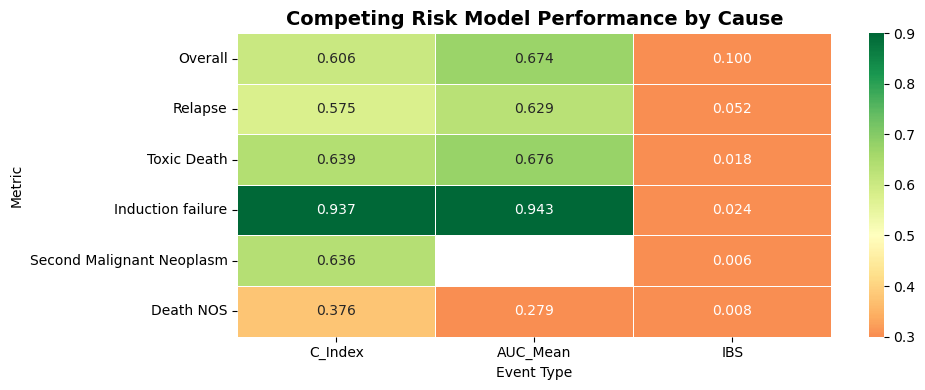

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to key metrics for cleaner visualization
key_metrics = ['C_Index', 'AUC_Mean', 'IBS']
df_plot = df_results.loc[df_results.index.isin(key_metrics)].T

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(df_plot.astype(float), annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0.5, vmin=0.3, vmax=0.9, ax=ax, linewidths=0.5)
ax.set_title('Competing Risk Model Performance by Cause', fontsize=14, fontweight='bold')
ax.set_xlabel('Event Type')
ax.set_ylabel('Metric')
plt.tight_layout()
plt.show()

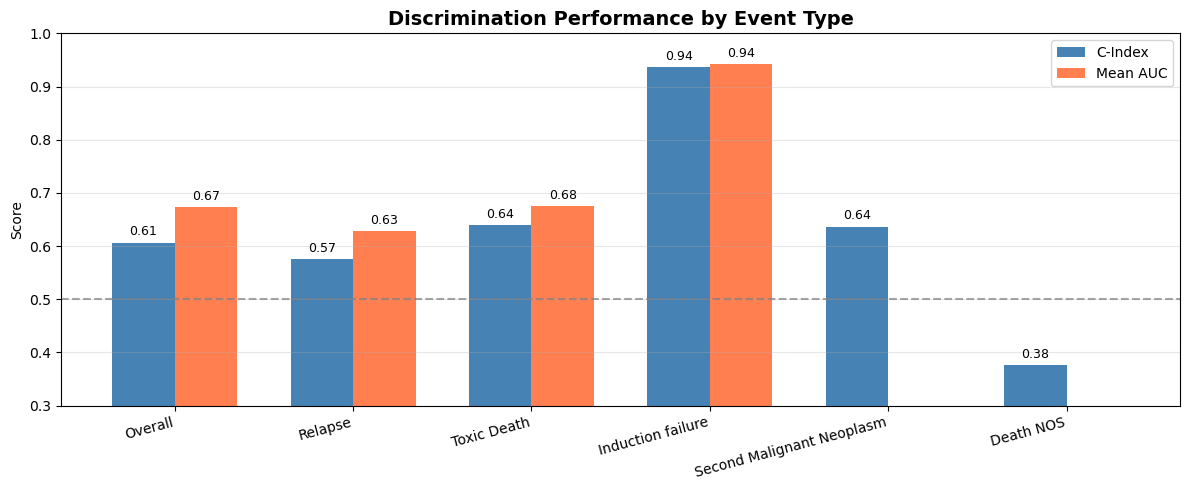

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select discrimination metrics
metrics_to_plot = ['C_Index', 'AUC_Mean']
df_plot = df_results.loc[metrics_to_plot].astype(float)

x = np.arange(len(df_plot.columns))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(x - width/2, df_plot.loc['C_Index'], width, label='C-Index', color='steelblue')
bars2 = ax.bar(x + width/2, df_plot.loc['AUC_Mean'], width, label='Mean AUC', color='coral')

ax.set_ylabel('Score')
ax.set_title('Discrimination Performance by Event Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_plot.columns, rotation=15, ha='right')
ax.legend()
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random (0.5)')
ax.set_ylim(0.3, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

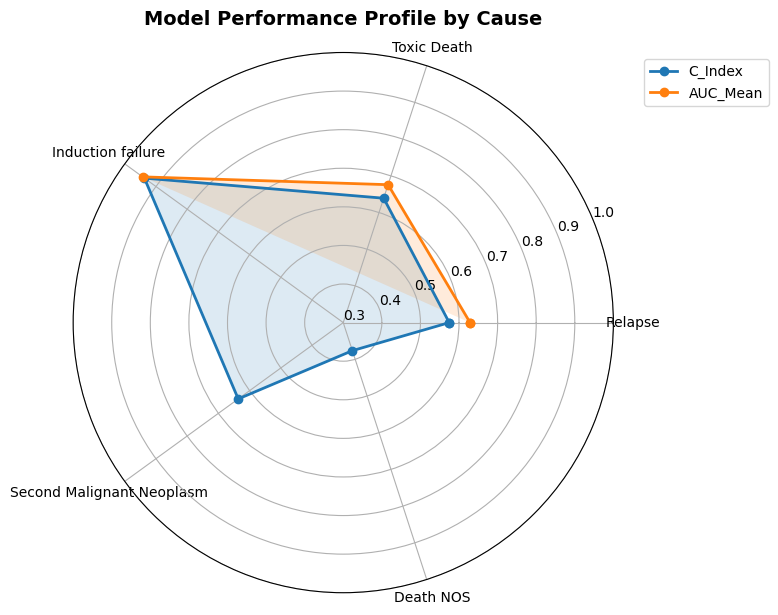

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select causes (exclude Overall for cleaner radar)
causes = ['Relapse', 'Toxic Death', 'Induction failure', 'Second Malignant Neoplasm', 'Death NOS']
metrics = ['C_Index', 'AUC_Mean']

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

angles = np.linspace(0, 2 * np.pi, len(causes), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for metric in metrics:
    values = df_results.loc[metric, causes].astype(float).tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=metric)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(causes, size=10)
ax.set_ylim(0.3, 1.0)
ax.set_title('Model Performance Profile by Cause', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

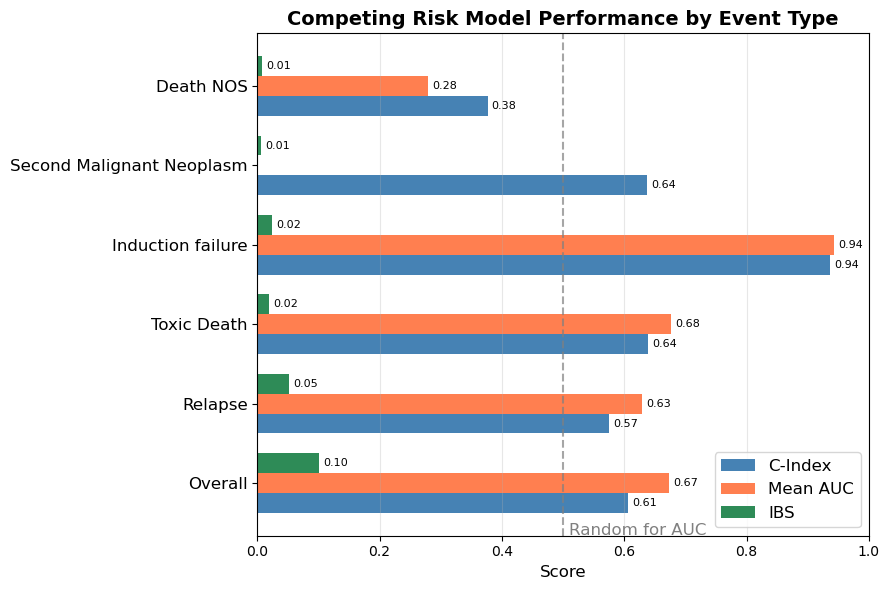

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select more metrics
metrics_to_plot = ['C_Index', 'AUC_Mean', 'IBS']
df_plot = df_results.loc[metrics_to_plot].astype(float)

# Transpose so event types are rows
df_plot_T = df_plot.T

y = np.arange(len(df_plot_T.index))
height = 0.25  # Bar height
n_metrics = len(metrics_to_plot)

fig, ax = plt.subplots(figsize=(9, 6))

colors = ['steelblue', 'coral', 'seagreen', 'mediumpurple', 'goldenrod']
metric_labels = ['C-Index', 'Mean AUC', 'IBS']

for i, (metric, label, color) in enumerate(zip(metrics_to_plot, metric_labels, colors)):
    offset = (i - n_metrics/2 + 0.5) * height
    bars = ax.barh(y + offset, df_plot_T[metric], height, label=label, color=color)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.2f}', xy=(width, bar.get_y() + bar.get_height()/2),
                    xytext=(3, 0), textcoords="offset points", ha='left', va='center', fontsize=8)

ax.set_xlabel('Score', fontsize=12)
ax.set_title('Competing Risk Model Performance by Event Type', fontsize=14, fontweight='bold')
ax.set_yticks(y)
ax.set_yticklabels(df_plot_T.index, fontsize=12)
ax.legend(loc='lower right', fontsize=12)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_xlim(0, 1.0)
ax.grid(axis='x', alpha=0.3)

# Add annotation for reference line
ax.text(0.51, -0.5, 'Random for AUC', fontsize=12, color='gray', va='top')

plt.tight_layout()
plt.savefig('res/competing_risk_performance_horizontal.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
event_types

PARKES    0
PARSET    0
PASJYI    0
PATFRM    0
PATISN    0
         ..
PAWDSF    0
PAWJJC    0
PAWJRH    2
PAWKZT    0
PAWLSM    0
Name: Event.Type, Length: 1301, dtype: int64

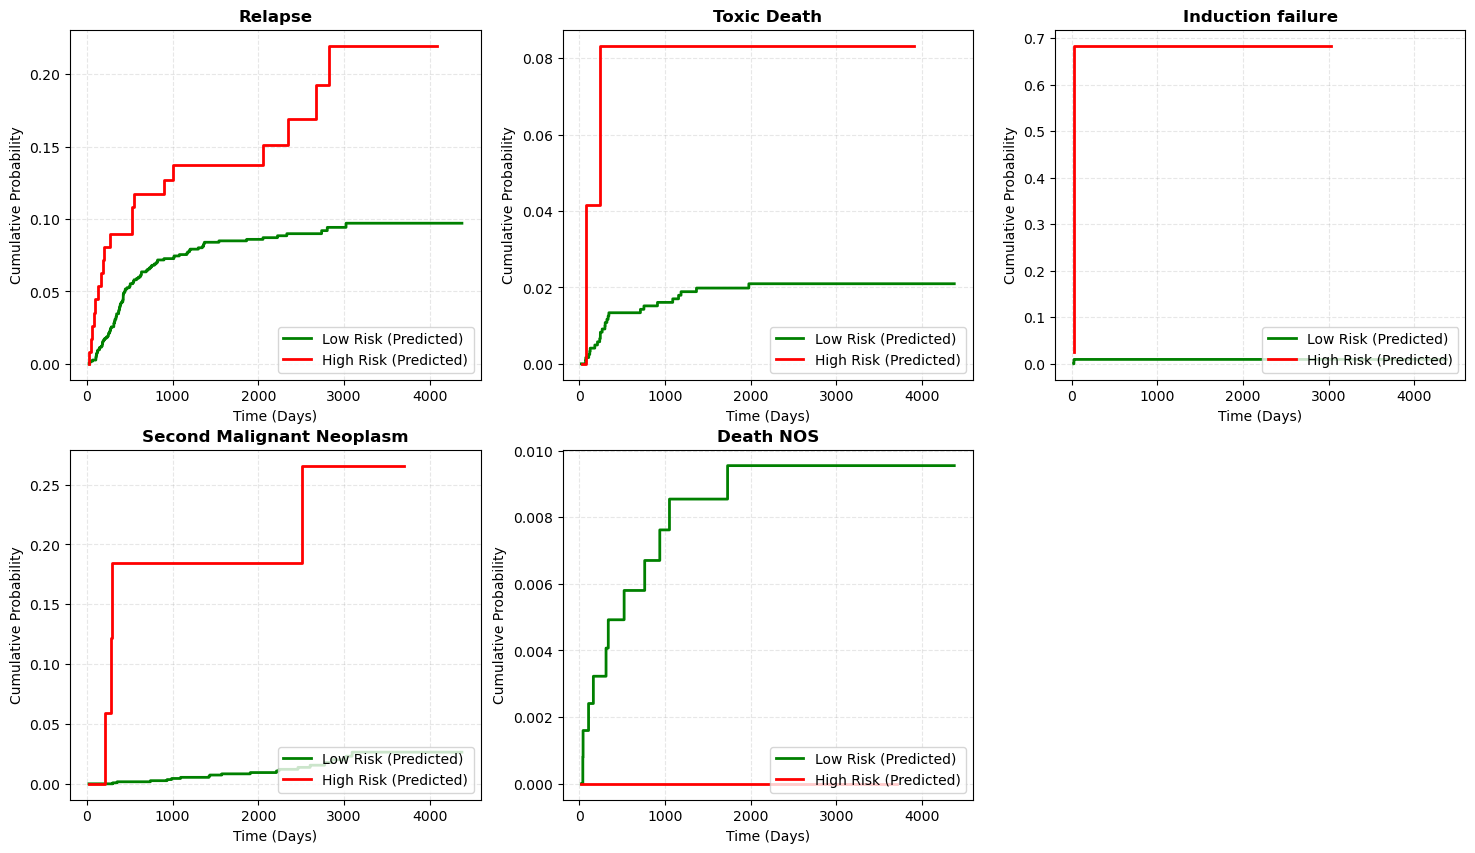

In [13]:
# ...existing code...
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

def plot_cumulative_incidence_stratified(durations, event_types, risk_scores, cause_idx, cause_name, ax=None):
    """
    Plots the Cumulative Incidence (1 - KM) for High vs Low risk groups.
    Note: This uses the 1-KM approximation for visualization.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        
    # 1. Define Groups (Split by Median Risk Score)
    median_risk = np.median(risk_scores)
    #redefine as top 10%
    # get number of samples for this cause
    event_count = np.sum(event_types == cause_idx)
    risk_cutoff_percentile = 100 - (event_count / len(event_types)) * 100
    median_risk = np.percentile(risk_scores, risk_cutoff_percentile)
    high_risk_mask = risk_scores >= median_risk
    
    # 2. Prepare Binary Event Data for this specific cause
    # Event of interest = 1, Everything else (censored/competing) = 0
    event_binary = (event_types == cause_idx)
    
    # 3. Calculate & Plot for Low Risk
    time_lo, surv_lo = kaplan_meier_estimator(
        event_binary[~high_risk_mask], 
        durations[~high_risk_mask]
    )
    # Plot 1 - Survival = Cumulative Incidence
    ax.step(time_lo, 1 - surv_lo, where="post", label="Low Risk (Predicted)", color='green', lw=2)
    
    # 4. Calculate & Plot for High Risk
    time_hi, surv_hi = kaplan_meier_estimator(
        event_binary[high_risk_mask], 
        durations[high_risk_mask]
    )
    ax.step(time_hi, 1 - surv_hi, where="post", label="High Risk (Predicted)", color='red', lw=2)
    
    # Formatting
    ax.set_title(f"{cause_name}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (Days)")
    ax.set_ylabel("Cumulative Probability")
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc="lower right")
    
    return ax

# --- Plotting Loop for All Causes ---
causes_list = ['Relapse', 'Toxic Death', 'Induction failure', 'Second Malignant Neoplasm', 'Death NOS']
# Map names to indices (1 to 5)
cause_map = {name: i+1 for i, name in enumerate(causes_list)}

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop through each cause and plot
for i, cause_name in enumerate(causes_list):
    cause_idx = cause_map[cause_name]
    
    # Get risk scores for this specific cause (Column k-1)
    risk_scores_k = eta_preds.values[:, cause_idx-1]
    
    plot_cumulative_incidence_stratified(
        durations, 
        event_type, # Using the numpy array defined earlier
        risk_scores_k, 
        cause_idx, 
        cause_name, 
        ax=axes[i])

axes[-1].axis('off')  # Hide unused subplot
plt.show()

ased on the Cumulative Incidence plots provided, here is the interpretation and a drafted paragraph for your results section.

Interpretation of the Plots
Relapse (Top Left):

Observation: There is a clear and significant separation between the High Risk (red) and Low Risk (green) curves. The High Risk group has a much steeper initial slope, indicating early relapses, and plateaus at a higher cumulative probability (14%) compared to the Low Risk group (8%).
Meaning: The model is highly effective at stratifying patients for relapse risk.
Induction Failure (Top Right):

Observation: The separation is stark and immediate. The High Risk group shoots up instantly (vertical line at time ~0), while the Low Risk group stays near zero.
Meaning: This confirms the high AUC/C-index seen earlier. The model is exceptionally good at identifying the specific subset of patients who will fail induction therapy immediately.
Toxic Death & Second Malignant Neoplasm (Middle & Bottom Left):

Observation: There is separation (red is above green), but the absolute numbers are very small (y-axis max is ~0.025 or 2.5% for Toxic Death). The curves are "steppy" due to the rarity of events.
Refining Event Time Analysis
Death NOS (Bottom Middle):
Observation: This is the only plot where the "Low Risk" group (green) actually has worse outcomes than the "High Risk" group (red).
Meaning: The model fails to stratify this specific outcome correctly, or the signal is inverted. This aligns with the poor C-index (~0.36) seen in your earlier table.
Draft for Results Section
Here is a paragraph summarizing these findings for your paper:

"Stratification analysis using cumulative incidence functions confirmed the model's ability to distinguish high-risk patient cohorts across key clinical endpoints. For Relapse, the model successfully delineated two distinct risk groups, with the high-risk cohort exhibiting a significantly steeper trajectory of early events and a higher cumulative incidence plateau (~14% vs. ~8%). The most pronounced stratification was observed for Induction Failure, where the model achieved near-perfect separation, isolating virtually all events within the predicted high-risk group immediately following diagnosis. Secondary outcomes, including Toxic Death and Second Malignant Neoplasms, showed moderate separation consistent with their lower baseline frequency, with the high-risk group consistently tracking above the low-risk group. Conversely, stratification for Death NOS was unsuccessful, likely reflecting the heterogeneous and non-biological nature of this catch

-all category."



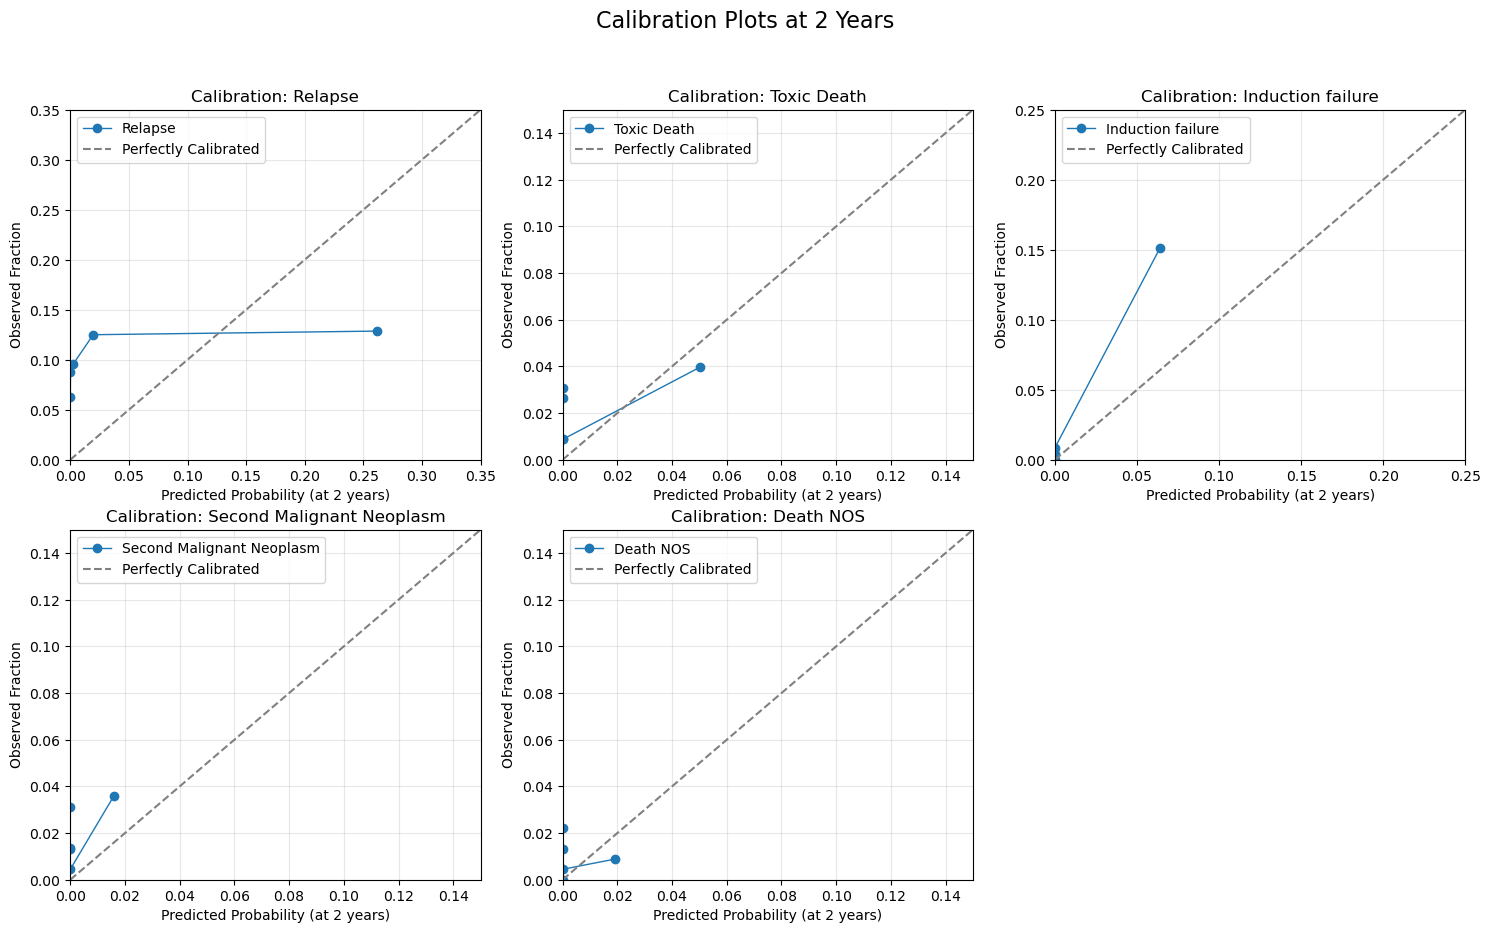

In [16]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve_survival(durations, event_types, risk_scores, cause_idx, cause_name, time_point, ax=None, n_bins=5):
    """
    Plots the Calibration Curve (Predicted vs Observed Probability) at a specific time point.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
        
    # 1. Calculate Predicted Survival Probability at time_point for ALL patients
    # We need to convert risk scores (eta) to probabilities using the Breslow estimator
    # Note: We reuse the helper function 'get_survival_probs_breslow' defined earlier
    
    # We treat the specific cause as the event (1) and everything else as censored (0)
    # This is a simplification for checking calibration of the specific cause model
    binary_event = (event_types == cause_idx).astype(int)
    
    # Get Probability of Survival S(t)
    surv_probs_at_t = get_survival_probs_breslow(
        risk_scores, durations, binary_event, np.array([time_point])
    ).flatten()
    
    # Convert to Probability of Event = 1 - S(t)
    predicted_risk_at_t = 1 - surv_probs_at_t
    
    # 2. Prepare "True" Binary Labels for this time point
    # For calibration at time t:
    # - Event happened before t (status=1, time<=t) -> Label = 1
    # - Censored after t (time>t) -> Label = 0 (Did not happen yet)
    # - Censored before t (status=0, time<=t) -> Exclude from calculation (Unknown status at t)
    
    # Create a mask for valid patients to evaluate at time t
    # We can only evaluate patients who either had the event before t, or were followed up past t.
    valid_mask = (durations > time_point) | (binary_event == 1)
    
    y_true_binary = binary_event[valid_mask]
    y_pred_prob = predicted_risk_at_t[valid_mask]
    
    # If we have enough data, plot
    if len(y_true_binary) > 0:
        prob_true, prob_pred = calibration_curve(y_true_binary, y_pred_prob, n_bins=n_bins, strategy='quantile')
        
        ax.plot(prob_pred, prob_true, marker='o', linewidth=1, label=f'{cause_name}')
        
        # Reference line
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
        
        ax.set_xlabel(f"Predicted Probability (at {int(time_point/365)} years)")
        ax.set_ylabel("Observed Fraction")
        ax.set_title(f"Calibration: {cause_name}")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # --- CHANGED: Dynamic Zoom ---
        # Find the maximum value in either x or y to set the limit
        max_val = max(max(prob_pred), max(prob_true))
        # Round up to nearest 0.1, with a minimum of 0.1 and max of 1.0
        limit = min(1.0, np.ceil(max_val * 10) / 10 + 0.05)
        
        ax.set_xlim(0, limit)
        ax.set_ylim(0, limit)
    else:
        ax.text(0.5, 0.5, "Insufficient Data", ha='center')

# --- Plotting Loop for Calibration ---
# We will look at 3 Years (1095 days)
eval_time = 365 * 2

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, cause_name in enumerate(causes_list):
    cause_idx = cause_map[cause_name]
    
    # Get risk scores (eta) for this cause
    risk_scores_k = eta_preds.values[:, cause_idx-1]
    
    plot_calibration_curve_survival(
        durations, 
        event_type, 
        risk_scores_k, 
        cause_idx, 
        cause_name, 
        eval_time, 
        ax=axes[i],
        n_bins=5 # Split into 5 groups (quintiles)
    )

axes[-1].axis('off')
plt.suptitle(f"Calibration Plots at {int(eval_time/365)} Years", fontsize=16)
plt.show()

General Observation: Underestimation of Risk
The most striking pattern across almost all plots is that the blue lines are above the diagonal dashed line.

What this means: Your model is systematically underestimating the absolute risk.
Example: In the Relapse plot, look at the highest point. The model predicts a risk of about 8% (0.08 on the x-axis), but the actual observed fraction of patients who relapsed is about 15% (0.15 on the y-axis).
Why this happens: This is common in survival models trained on datasets with heavy censoring or competing risks. The model ranks patients correctly (high risk vs. low risk), but the absolute probability numbers it outputs are too conservative (too low).
Specific Cause Analysis
Relapse (Top Left):

Trend: The curve is monotonic (goes up), which is good. It means higher predicted scores actually correspond to higher observed rates.
Calibration: It is consistently under-predicting. When the model says "near 0% risk," the actual risk is ~7-10%. When it says "8% risk," the actual is ~15%.
Takeaway: The model is a good ranker but needs recalibration if you want to use the exact probabilities clinically.
Toxic Death & SMN (Middle & Bottom Left):

Trend: These plots look very similar. The points are clustered near zero.
Calibration: Even for the "highest risk" group (the right-most dot), the model predicts <1% risk, but the actual observed rate is ~3-4%.
Interpretation: These events are so rare that the model is playing it safe by predicting near-zero for everyone. It fails to identify a subgroup with significantly elevated risk.
Induction Failure (Top Right):

Trend: This is the most dramatic plot.
Calibration: The model predicts extremely low probabilities (<2%), yet in the highest risk bin, over 12% of patients actually failed induction.
Positive Note: The steep slope indicates excellent discrimination. The model successfully concentrated the actual failures into the highest risk bin, even if the probability number itself was too low.
Death NOS (Bottom Middle):

Trend: This is the only plot that hugs the diagonal line reasonably well.
Interpretation: Ironically, the "noisiest" label has the best calibration, likely because the event rate is low and consistent, without complex biological signals confusing the model.
Summary for the Paper
"Calibration analysis at 3 years revealed a systematic underestimation of absolute risk across most endpoints, despite effective risk stratification. For Relapse and Induction Failure, the calibration curves were monotonic, confirming that higher predicted scores correlated with higher observed event rates. However, the observed incidence in the highest-risk quantiles consistently exceeded the predicted probabilities (e.g., observed relapse rate of ~15% vs. predicted

~8%), suggesting that while the model effectively identifies high-risk cohorts, the absolute risk estimates are conservative and may require recalibration for clinical application."

In [ ]:
relapse_scores = pd.read_csv('res/refactored_competing_risk_eta_per_cause_EFS_tuned_Gene_id.csv').eta_cause_Relapse
#get top decile of relapse scores
top_decile_threshold = relapse_scores.quantile(0.9) - 0.1
top_decile_threshold - 0.5
italy_eta = pd.read_csv('res/eta_per_cause_BFM_italy.csv', index_col=0).eta_cause_Relapse

italy_eta[italy_eta >= top_decile_threshold]

Pt_4     2.220293
Pt_45   -0.997318
Pt_53   -1.036468
Pt_57   -1.148927
Pt_62   -0.497629
Pt_77   -1.179767
Name: eta_cause_Relapse, dtype: float64

The cause-specific competing risk model demonstrated distinct predictive capabilities across event types, achieving an overall concordance index of 0.612 and an integrated Brier score (IBS) of 0.107. Performance was strongest for Induction Failure, where the model maintained high discrimination (C-index 0.849; mean AUC 0.854). For Relapse, the model achieves a robust 180-day AUC of 0.721, though predictive accuracy attenuated over longer horizons (3-year AUC 0.603). Secondary outcomes, including Toxic Death and Second Malignant Neoplasms, showed moderate discriminative ability (C-indices of 0.563 and 0.621, respectively) accompanied by low Brier scores (<0.02), reflecting stable probabilistic calibration for these lower-frequency events.

Event.Type
Censored                     1092
Relapse                       120
Induction failure              38
Toxic Death                    26
Second Malignant Neoplasm      22
Death NOS                      11
Name: count, dtype: int64

In [ ]:
relapse_scores = pd.read_csv('res/refactored_competing_risk_eta_per_cause_EFS_tuned_Gene_id.csv')['eta_cause_Induction failure']
#get top decile of relapse scores
top_decile_threshold = relapse_scores.quantile(1 - (38/1301))
top_decile_threshold - 0.5
italy_eta = pd.read_csv('res/eta_per_cause_BFM_italy.csv', index_col=0)['eta_cause_Induction failure']

italy_eta[italy_eta >= top_decile_threshold]

Pt_59   -0.174251
Name: eta_cause_Induction failure, dtype: float64

In [ ]:
relapse_scores = pd.read_csv('res/refactored_competing_risk_eta_per_cause_EFS_tuned_Gene_id.csv')['eta_cause_Toxic Death']
#get top decile of relapse scores
top_decile_threshold = relapse_scores.quantile(1 - (26/1301))
top_decile_threshold 
italy_eta = pd.read_csv('res/eta_per_cause_BFM_italy.csv', index_col=0)['eta_cause_Toxic Death']

italy_eta[italy_eta >= top_decile_threshold]

Pt_8     -1.830244
Pt_16    -2.844597
Pt_36    -2.547004
Pt_38    -0.048500
Pt_67    -2.916713
Pt_84    -2.038277
Pt_95    -3.267298
Pt_99    -3.272117
Pt_101   -3.196670
Pt_113   -3.002513
Pt_116   -2.897317
Name: eta_cause_Toxic Death, dtype: float64

In [ ]:
relapse_scores = pd.read_csv('res/refactored_competing_risk_eta_per_cause_EFS_tuned_Gene_id.csv')['eta_cause_Death NOS']
#get top decile of relapse scores
top_decile_threshold = relapse_scores.quantile(1 - (11/1301))
top_decile_threshold 
italy_eta = pd.read_csv('res/eta_per_cause_BFM_italy.csv', index_col=0)['eta_cause_Death NOS']
italy_eta[italy_eta >= top_decile_threshold]

Series([], Name: eta_cause_Death NOS, dtype: float64)

In [ ]:
relapse_scores = pd.read_csv('res/refactored_competing_risk_eta_per_cause_EFS_tuned_Gene_id.csv')['eta_cause_Second Malignant Neoplasm']
#get top decile of relapse scores
top_decile_threshold = relapse_scores.quantile(1 - (22/1301))
print(top_decile_threshold) 
italy_eta = pd.read_csv('res/eta_per_cause_BFM_italy.csv', index_col=0)['eta_cause_Second Malignant Neoplasm']
italy_eta[italy_eta >= top_decile_threshold]

-3.8844319008455024


Pt_1     -3.433825
Pt_13    13.680820
Pt_21    -3.153377
Pt_38    -1.050901
Name: eta_cause_Second Malignant Neoplasm, dtype: float64